In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy.cluster.hierarchy import dendrogram, linkage
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets import make_blobs
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from sklearn.metrics import silhouette_score
import umap

c:\Users\tere1\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
folder_path = r"C:\Users\tere1\OneDrive\Escritorio\TFM\datos_img"
# Cargar las características normalizadas por Z-score
df_fourier_z = pd.read_csv(os.path.join(folder_path, "features_fourier_all_zscore.csv"))
# Cargar las características normalizadas por Min-Max
df_fourier_mm = pd.read_csv(os.path.join(folder_path, "features_fourier_all_minmax.csv"))

In [3]:
#Se eliminan los datos no numéricos: 'label' y 'filename'
df_fourier_z_cl= df_fourier_z.drop(columns=['filename', 'label'])

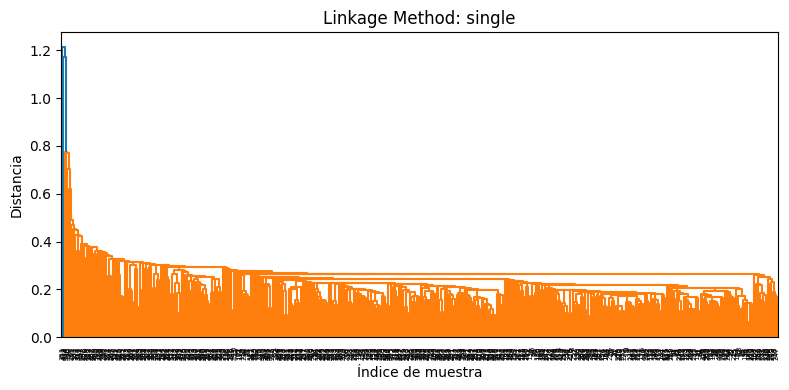

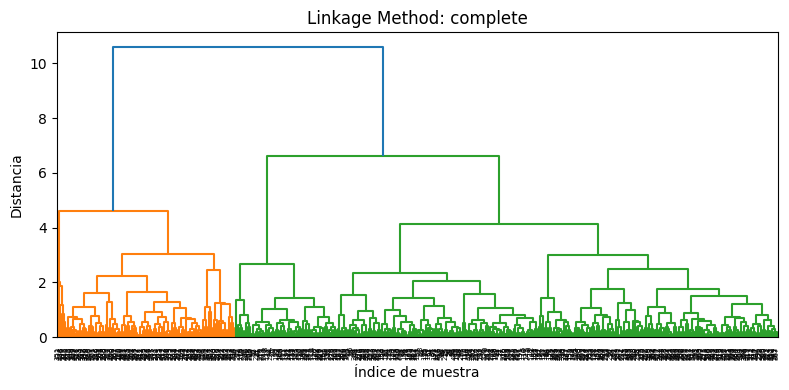

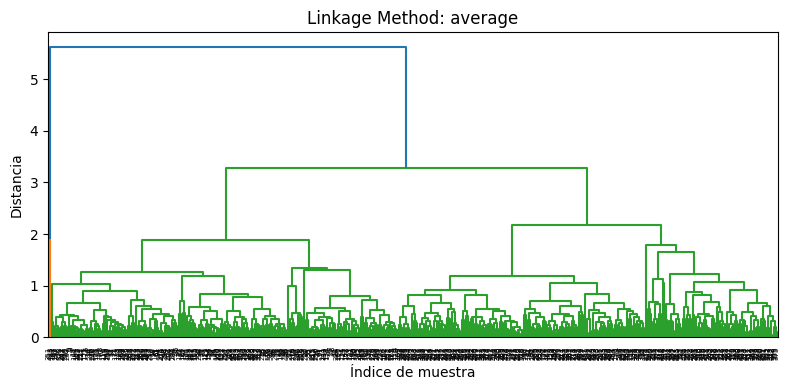

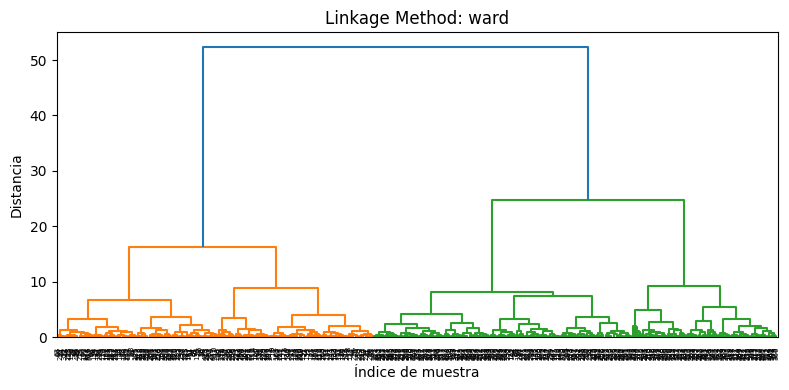

In [4]:
# Comparar diferentes métodos de linkage
methods = ['single', 'complete', 'average', 'ward']

for method in methods:
    clusters = linkage(df_fourier_z_cl, method=method)
    plt.figure(figsize=(8, 4))
    dendrogram(clusters)
    plt.title(f'Linkage Method: {method}')
    plt.xlabel('Índice de muestra')
    plt.ylabel('Distancia')
    plt.tight_layout()
    plt.show()

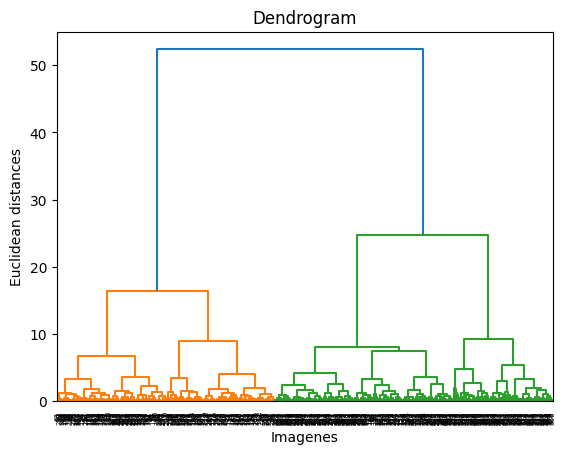

In [5]:
# Using the dendrogram to find the optimal number of clusters
dendrogram = sch.dendrogram(sch.linkage(df_fourier_z_cl, method = 'ward'))
plt.title('Dendrogram')
plt.xlabel('Imagenes')
plt.ylabel('Euclidean distances')
plt.show()

Se podría "cortar" entre 20-30, por tanto, 2 clusteres-

In [6]:
hc_z = AgglomerativeClustering(n_clusters = 2, metric = 'euclidean', linkage = 'ward')
y_hc_z = hc_z.fit_predict(df_fourier_z_cl)


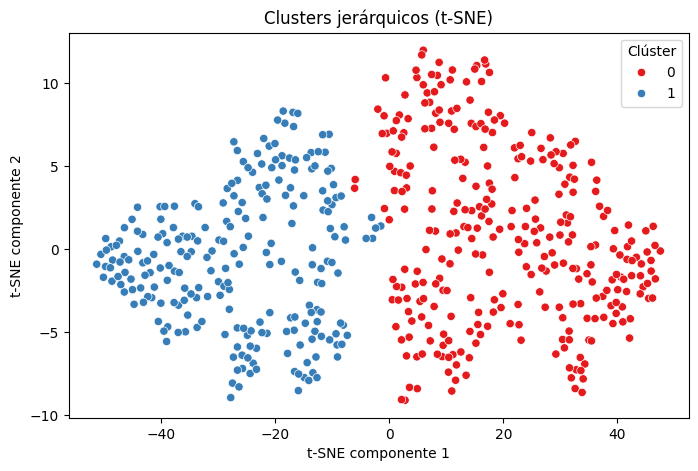

          filename    label  cluster
0      callo_1.png  smaller        1
1     callo_10.png  smaller        0
2    callo_100.png  smaller        1
3    callo_101.png  smaller        1
4    callo_102.png  smaller        1
..             ...      ...      ...
532   callo_95.png   higher        0
533   callo_96.png   higher        0
534   callo_97.png   higher        0
535   callo_98.png   higher        0
536   callo_99.png   higher        0

[537 rows x 3 columns]


In [7]:
#Visualización alternativa con t-SNE (
tsne_z = TSNE(n_components=2, random_state=42)
X_tsne_z = tsne_z.fit_transform(df_fourier_z_cl)

plt.figure(figsize=(8, 5))
sns.scatterplot(x=X_tsne_z[:, 0], y=X_tsne_z[:, 1], hue=y_hc_z, palette='Set1')
plt.title('Clusters jerárquicos (t-SNE)')
plt.xlabel('t-SNE componente 1')
plt.ylabel('t-SNE componente 2')
plt.legend(title='Clúster')
plt.show()

df_resultado_z = pd.DataFrame({
    'filename': df_fourier_z['filename'], 
    'label': df_fourier_z['label'],
    'cluster': y_hc_z
})

print(df_resultado_z)

c:\Users\tere1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\tere1\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


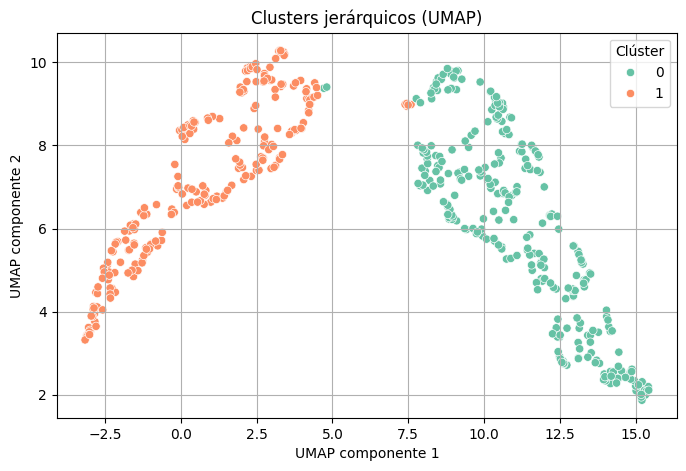

In [8]:
umap_z = umap.UMAP(n_components=2, random_state=42)
X_umap_z = umap_z.fit_transform(df_fourier_z_cl)


plt.figure(figsize=(8, 5))
sns.scatterplot(x=X_umap_z[:, 0], y=X_umap_z[:, 1], hue=y_hc_z, palette='Set2')
plt.title('Clusters jerárquicos (UMAP)')
plt.xlabel('UMAP componente 1')
plt.ylabel('UMAP componente 2')
plt.legend(title='Clúster')
plt.grid(True)
plt.show()

In [9]:
# Crear la tabla de contingencia entre 'label' y 'cluster'
contingency_table = pd.crosstab(df_resultado_z['label'], df_resultado_z['cluster'])

# Mostrar la tabla de contingencia
print(contingency_table)


cluster    0    1
label            
higher   241   27
smaller   60  209


In [10]:
# y_hc_z son las etiquetas del clustering, df_fourier_z_cl los datos
score = silhouette_score(df_fourier_z_cl, y_hc_z)
print(f'Silhouette Score: {score:.3f}')


Silhouette Score: 0.526


Se hace lo mismo pero con los datos normalizados min-max

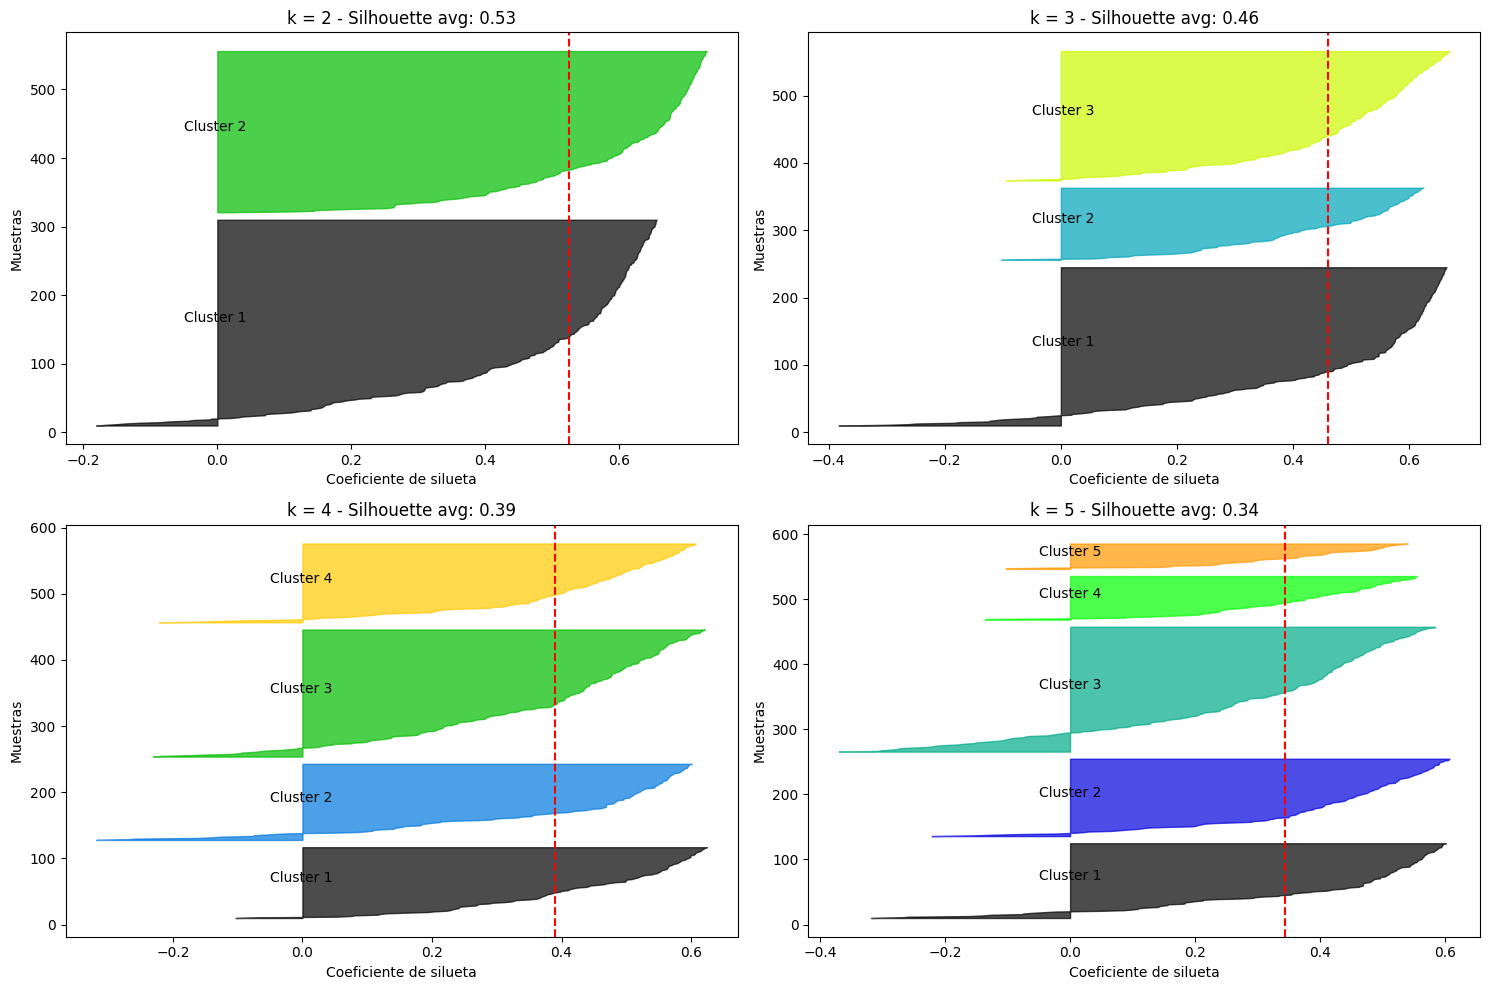

In [11]:

fig, ax = plt.subplots(2, 2, figsize=(15, 10))

# Probar con 2, 3, 4 y 5 clusters
for i, k in enumerate([2, 3, 4, 5]):
    clusterer = AgglomerativeClustering(n_clusters=k, linkage='ward', metric='euclidean')
    labels = clusterer.fit_predict(df_fourier_z_cl)
    silhouette_vals = silhouette_samples(df_fourier_z_cl, labels)
    silhouette_avg = silhouette_score(df_fourier_z_cl, labels)

    # Subplot row/col
    row = i // 2
    col = i % 2
    ax_i = ax[row][col]
    y_lower = 10

    for j in range(k):
        j_silhouette_vals = silhouette_vals[labels == j]
        j_silhouette_vals.sort()
        size = len(j_silhouette_vals)
        y_upper = y_lower + size
        color = cm.nipy_spectral(float(j) / k)
        ax_i.fill_betweenx(np.arange(y_lower, y_upper), 0, j_silhouette_vals,
                           facecolor=color, edgecolor=color, alpha=0.7)
        ax_i.text(-0.05, y_lower + size / 2, f'Cluster {j+1}')
        y_lower = y_upper + 10

    ax_i.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax_i.set_title(f'k = {k} - Silhouette avg: {silhouette_avg:.2f}')
    ax_i.set_xlabel("Coeficiente de silueta")
    ax_i.set_ylabel("Muestras")

plt.tight_layout()
plt.show()

Con dos clusteres se obtiene la mejor silueta y además la mayoría de las imagenes higher están en un cluster y las smaller en otro, por tanto, esto nos podría decir que podemos encontrar diferencias que permiten separar estos dos grupos de callos a partir de la tranformada de fourier.

In [12]:
#Se eliminan los datos no numéricos: 'label' y 'filename'
df_fourier_mm_cl= df_fourier_mm.drop(columns=['filename', 'label'])

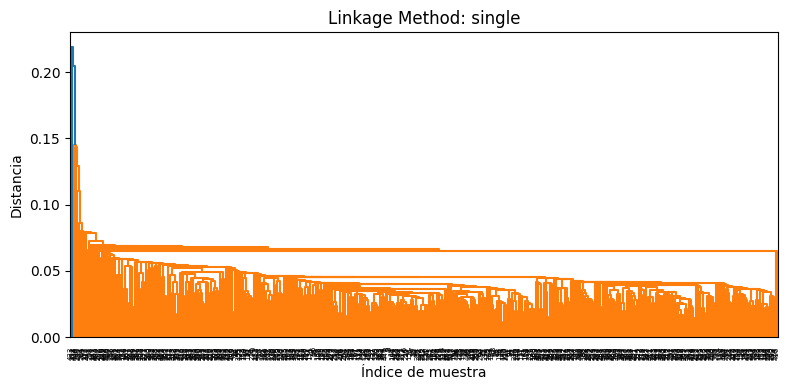

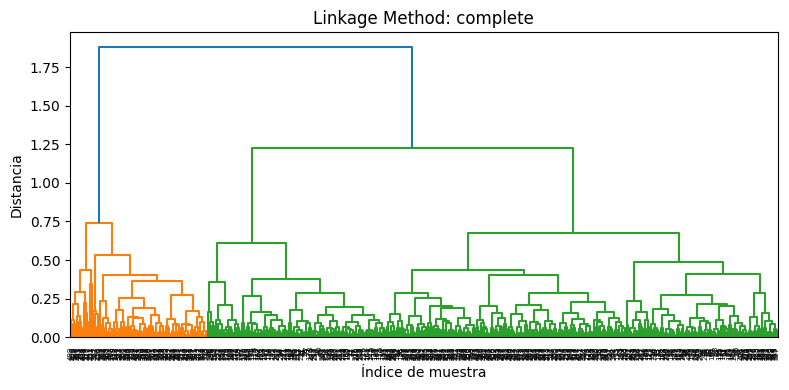

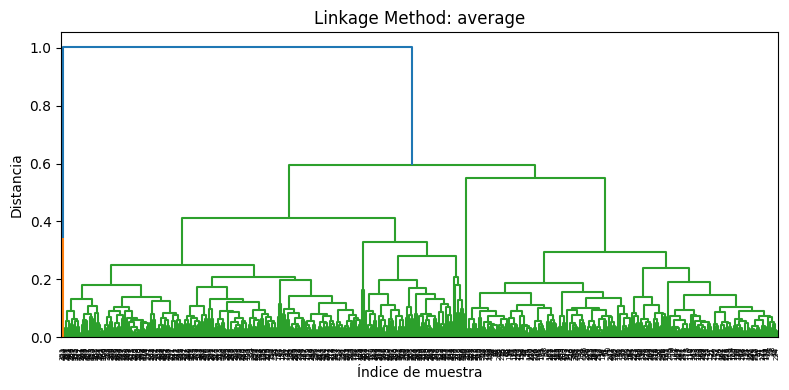

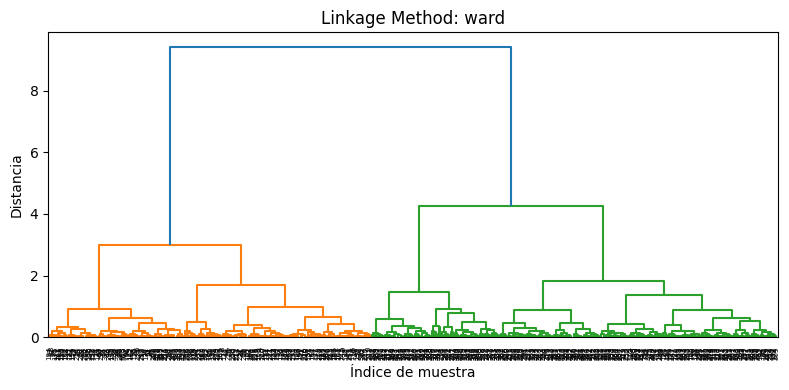

In [13]:
from scipy.cluster.hierarchy import dendrogram, linkage
methods_2 = ['single', 'complete', 'average', 'ward']

# Asegúrate de tener df_fourier_mm_cl bien definido antes de este paso
for method in methods_2:
    clusters_mm = linkage(df_fourier_mm_cl, method=method)  # Calcular el linkage
    plt.figure(figsize=(8, 4))
    dendrogram(clusters_mm)  
    plt.title(f'Linkage Method: {method}')
    plt.xlabel('Índice de muestra')
    plt.ylabel('Distancia')
    plt.tight_layout()
    plt.show()

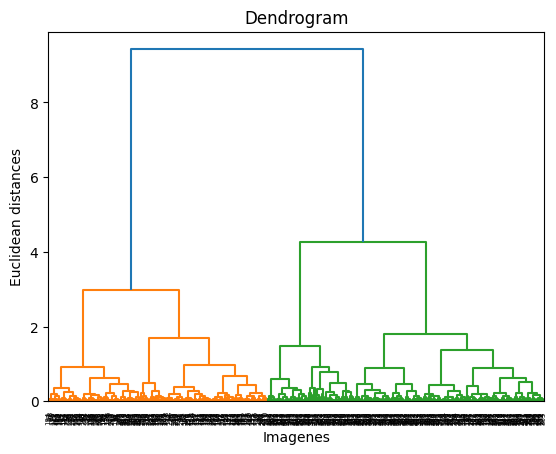

In [14]:
# Using the dendrogram to find the optimal number of clusters
dendrogram = sch.dendrogram(sch.linkage(df_fourier_mm_cl, method = 'ward'))
plt.title('Dendrogram')
plt.xlabel('Imagenes')
plt.ylabel('Euclidean distances')
plt.show()

In [15]:
hc_mm = AgglomerativeClustering(n_clusters = 2, metric = 'euclidean', linkage = 'ward')
y_hc_mm = hc_mm.fit_predict(df_fourier_mm_cl)

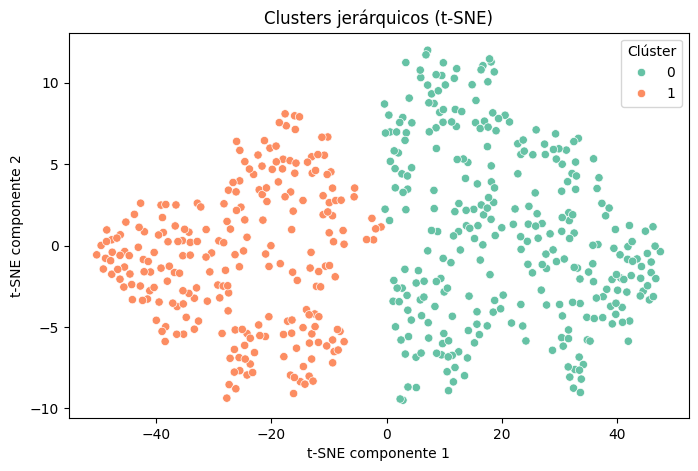

        filename    label  cluster
0    callo_1.png  smaller        1
1   callo_10.png  smaller        0
2  callo_100.png  smaller        1
3  callo_101.png  smaller        1
4  callo_102.png  smaller        1


In [16]:
#Visualización alternativa con t-SNE 
tsne_mm = TSNE(n_components=2, random_state=42)
X_tsne_mm = tsne_mm.fit_transform(df_fourier_mm_cl)

plt.figure(figsize=(8, 5))
sns.scatterplot(x=X_tsne_mm[:, 0], y=X_tsne_mm[:, 1], hue=y_hc_mm, palette='Set2')
plt.title('Clusters jerárquicos (t-SNE)')
plt.xlabel('t-SNE componente 1')
plt.ylabel('t-SNE componente 2')
plt.legend(title='Clúster')
plt.show()

df_resultado_mm = pd.DataFrame({
    'filename': df_fourier_mm['filename'], 
    'label': df_fourier_mm['label'],
    'cluster': y_hc_mm
})

print(df_resultado_mm.head())

c:\Users\tere1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\tere1\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


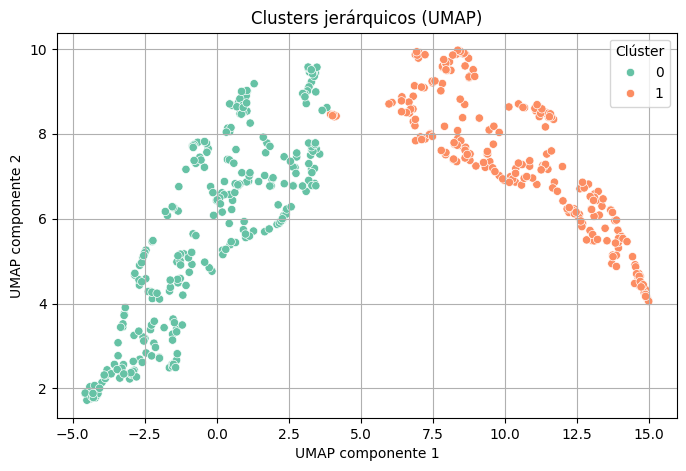

In [17]:
umap_mm = umap.UMAP(n_components=2, random_state=42)
X_umap_mm = umap_mm.fit_transform(df_fourier_mm_cl)


plt.figure(figsize=(8, 5))
sns.scatterplot(x=X_umap_mm[:, 0], y=X_umap_mm[:, 1], hue=y_hc_mm, palette='Set2')
plt.title('Clusters jerárquicos (UMAP)')
plt.xlabel('UMAP componente 1')
plt.ylabel('UMAP componente 2')
plt.legend(title='Clúster')
plt.grid(True)
plt.show()

In [18]:
# Crear la tabla de contingencia entre 'label' y 'cluster'
contingency_table_mm = pd.crosstab(df_resultado_mm['label'], df_resultado_mm['cluster'])

# Mostrar la tabla de contingencia
print(contingency_table_mm)


cluster    0    1
label            
higher   239   29
smaller   60  209


In [19]:
# y_hc_z son las etiquetas del clustering, df_fourier_z_cl los datos
score_mm = silhouette_score(df_fourier_mm_cl, y_hc_mm)
print(f'Silhouette Score: {score_mm:.3f}')

Silhouette Score: 0.527
